<h1>
<center> CFRM521 Group Project </center>
</h1>

<h1>
<center> Predict the short-term future trend and volatility level of SPY  </center>
</h1>

<h2>
<center> Chaoyi Lou, Zurui Chen, Joice Dong, Ruibo Wei  </center>
</h2>

# Section 1 --- Problem Statement

### Industry background

Recent years, many traders employ speculative trading strategies to conduct swing trading. They hold a long or short position on a tradable asset for between one and several days in an effort to profit from price changes. In this case, it is important for these traders to determine the future trend and volatility level of the asset’s price so that they can conduct appropriate trades. These traders focus more on trading behaviors in the market so that they may employ technical indicators to guide trading. In this project, our group will perfrom varied machine learning alogrithms to learn how the combination of indicators can tell us the price movement in near future, which can help us generate systematic investment recommendation, position solution and option's hedging risk management.

### Goal

We conduct analysis to the selected indicators from price trend, momentum, trading volume, and volatility indicators. We aim to fit classification model that will tell traders the trend and volatility level in the future days. We are interested in find result that “By the historical performance in the previous days, the SPY will have X% uptrend/downtrend; with a possible Y% move in range of Z volatility level in the next trading day(s).” 

# Section 2 --- Data extraction and preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import pyplot 

In [2]:
import pandas_datareader.data as web
import numpy as np
import pandas as pd

stock = "SPY"
data =  web.DataReader(stock,data_source="yahoo",start='2012-06-01',end = '2019-12-31')
data

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-06-01,131.500000,128.160004,129.410004,128.160004,253240900.0,109.072281
2012-06-04,128.740005,127.139999,128.389999,128.100006,202545800.0,109.021233
2012-06-05,129.259995,127.779999,127.849998,129.070007,164149400.0,109.846779
2012-06-06,132.029999,129.929993,129.970001,131.970001,184202800.0,112.314842
2012-06-07,133.529999,131.779999,133.470001,132.050003,184772700.0,112.382935
...,...,...,...,...,...,...
2019-12-24,321.519989,320.899994,321.470001,321.230011,20270000.0,319.352142
2019-12-26,322.950012,321.640015,321.649994,322.940002,30911200.0,321.052124
2019-12-27,323.799988,322.279999,323.739990,322.859985,42528800.0,320.972565


In [3]:
def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return (100 * up / (up + down))

In [4]:
## RSI relative strength index (RSI) is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold 
data['Momentum_1D'] = (data['Close']-data['Close'].shift(1)).fillna(0)
data['Momentum_5D'] = (data['Close']-data['Close'].shift(5)).fillna(0)
data['Momentum_10D'] = (data['Close']-data['Close'].shift(10)).fillna(0)
data['RSI_14D'] = data['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)

In [5]:
### Bolling Brand
def bollingerbands(price, length=21, num_sd=2):
    """ returns middle, upper band, and lower band"""
    mid = price.rolling(window = length, center = False).mean()
    sd = price.rolling(window = length, center = False).std()
    upperband = mid + (sd*num_sd)
    lowerband = mid - (sd*num_sd)
    return np.round(mid,3), np.round(upperband,3), np.round(lowerband,3)

In [6]:
data['BB_Middle_Band'], data['BB_Upper_Band'], data['BB_Lower_Band'] = bollingerbands(data['Close'], length=21, num_sd=2)
data['BB_Middle_Band'] = data['BB_Middle_Band'].fillna(0)
data['BB_Upper_Band'] = data['BB_Upper_Band'].fillna(0)
data['BB_Lower_Band'] = data['BB_Lower_Band'].fillna(0)

In [7]:
## SMA
data['SMA_20'] = data['Close'].rolling(window =20).mean()
data['SMA_100'] = data['Close'].rolling(window =100).mean()

**Exponential Moving Average**

EMA = EMA(1) + α * (Close – EMA(1))

α = 2 / (N + 1)

N = The smoothing period.

In [8]:
## MACD Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. 
## The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA
data['26_EMA'] = data['Close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
data['12_EMA'] = data['Close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
data['MACD'] = data['12_EMA'] - data['26_EMA']
data['MACD_signal'] =data['MACD'].ewm(span=9, adjust=False).mean()

**Average True Range**

True Range = Highest of (HIgh - low, abs(High - previous close), abs(low - previous close))

Average True Range = 14 day MA of True Range

**Average Directional Movement Index (ADX)**

(1). +DM and -DM are calculated using the High, Low and Close for each period. You can then calculate the following:

Current High - Previous High = UpMove Previous Low - Current Low = DownMove

If UpMove > DownMove and UpMove > 0, then +DM = UpMove, else +DM = 0 

If DownMove > Upmove and Downmove > 0, then -DM = DownMove, else -DM = 0

(2). +DI = 100 times Exponential Moving Average of (+DM / Average True Range) -DI = 100 times Exponential Moving Average of (-DM / Average True Range)
.

ADX = 100 times the Exponential Moving Average of the |(+DI - -DI) / (+DI + -DI)|

In [9]:
# Calculation of Average Directional Movement Index (ADX)
def DMI(df, period):
    df1 = df.copy()
    df1['highlow'] = df1['High'] - df1['High']
    df1['abshighclose'] = abs(df1['High']-df1['Close'].shift(1))
    df1['abslowclose'] = abs(df1['Low']-df1['Close'].shift(1))
    
    df1['UpMove'] = df1['High'] - df1['High'].shift(1)
    df1['DownMove'] = df1['Low'].shift(1) - df1['Low']
    df1['Zero'] = 0

    df1['DM_plus'] = np.where((df1['UpMove'] > df1['DownMove']) & (df1['UpMove'] > df1['Zero']), 
                            df1['UpMove'], 0)
    df1['DM_minus'] = np.where((df1['UpMove'] < df1['DownMove']) & (df1['DownMove'] > df1['Zero']),
                             df1['DownMove'], 0)
    df1['TR'] = df1[['highlow','abshighclose','abslowclose']].max(axis=1)
    df['ATR'] = df1['TR'].rolling(window=14).mean()

    df['DI_plus'] = 100 * (df1['DM_plus']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
    df['DI_minus'] = 100 * (df1['DM_minus']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()

    df['ADX'] = 100 * (abs((df['DI_plus'] - df['DI_minus'])/(df['DI_plus'] + df['DI_minus']))).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()

DMI(data, 14)

### Extract past 7 year's market data for this project

In [10]:
data["pct"] = data['Close'].pct_change()
#df = pd.read_csv("CFRM_521_SPY.csv", index_col=0)
df = data.loc['2013-01-01':'2019-12-31']
df

,High,Low,Open,Close,Volume,Adj Close,Momentum_1D,Momentum_5D,Momentum_10D,RSI_14D,...,SMA_100,26_EMA,12_EMA,MACD,MACD_signal,ATR,DI_plus,DI_minus,ADX,pct
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,146.149994,144.729996,145.110001,146.059998,192059000.0,126.508362,3.649994,3.709991,2.289993,64.211520,...,142.468700,142.452345,142.894273,0.441928,0.441519,1.652140,54.876919,32.314073,22.449076,0.025630
2013-01-03,146.369995,145.339996,145.990005,145.729996,144761800.0,126.222488,-0.330002,3.979996,0.360001,69.744501,...,142.521100,142.695137,143.330538,0.635401,0.480296,1.624283,49.365932,28.005530,23.136879,-0.002259
2013-01-04,146.610001,145.669998,145.970001,146.369995,116817700.0,126.776825,0.639999,4.809998,2.080002,67.134156,...,142.578700,142.967351,143.798147,0.830796,0.550396,1.598570,44.785643,24.271459,24.012777,0.004392
2013-01-07,146.110001,145.429993,145.850006,145.970001,110002500.0,126.430382,-0.399994,5.940002,0.850006,67.544682,...,142.630000,143.189772,144.132278,0.942506,0.628818,1.612141,38.814224,23.020248,24.216720,-0.002733
2013-01-08,145.910004,144.979996,145.710007,145.550003,121265100.0,126.066605,-0.419998,3.139999,2.760010,69.113926,...,142.677800,143.364605,144.350390,0.985784,0.700211,1.557856,33.638994,23.802303,23.271127,-0.002877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,321.519989,320.899994,321.470001,321.230011,20270000.0,319.352142,0.010010,1.660004,7.700012,67.076614,...,301.638199,315.278385,318.588601,3.310215,3.046026,1.499285,31.481583,10.573711,40.107975,0.000031
2019-12-26,322.950012,321.640015,321.649994,322.940002,30911200.0,321.052124,1.709991,3.350006,8.519989,69.183954,...,302.029399,315.845913,319.258047,3.412135,3.119248,1.559285,39.512066,9.163883,43.073230,0.005323
2019-12-27,323.799988,322.279999,323.739990,322.859985,42528800.0,320.972565,-0.080017,1.959991,5.729980,70.675046,...,302.379999,316.365474,319.812192,3.446718,3.184742,1.385712,42.422265,7.942032,46.458354,-0.000248


# Section 3 --- Algorithms 

<h2>
<center> Predict SPY's Volatility in df8 </center>
</h2>

### Note: label '3' represent SPY up more than 5% today, label '2' represent SPY up 2% ~ 5% today, label '1' represent SPY up 0% ~ 2% today. While label '-3' represent SPY was down more than 5% today, label '-2' represent SPY was down 2% ~ 5% today, label '-1' represent SPY was down 0% ~ 2% today. 

### We predict next day's volatiliy base on the past day's indicators

In [11]:
df8 = df.copy()
col = 'pct'
conditions  = [(df8[col] >= 0.03), 
               (df8[col] < 0.03) & (df8[col]>= 0.015),
               (df8[col] < 0.015) & (df8[col]>= 0.00),
               (df8[col] < 0.00) & (df8[col]>= -0.015),
               (df8[col] < -0.015) & (df8[col]>= -0.03),
               (df8[col] <= -0.03) 
              ]
choices  = ['3','2','1','-1','-2','-3' ]

df8['price_movement'] = np.select(conditions, choices, default = np.nan)
df8

,High,Low,Open,Close,Volume,Adj Close,Momentum_1D,Momentum_5D,Momentum_10D,RSI_14D,...,26_EMA,12_EMA,MACD,MACD_signal,ATR,DI_plus,DI_minus,ADX,pct,price_movement
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,146.149994,144.729996,145.110001,146.059998,192059000.0,126.508362,3.649994,3.709991,2.289993,64.211520,...,142.452345,142.894273,0.441928,0.441519,1.652140,54.876919,32.314073,22.449076,0.025630,2
2013-01-03,146.369995,145.339996,145.990005,145.729996,144761800.0,126.222488,-0.330002,3.979996,0.360001,69.744501,...,142.695137,143.330538,0.635401,0.480296,1.624283,49.365932,28.005530,23.136879,-0.002259,-1
2013-01-04,146.610001,145.669998,145.970001,146.369995,116817700.0,126.776825,0.639999,4.809998,2.080002,67.134156,...,142.967351,143.798147,0.830796,0.550396,1.598570,44.785643,24.271459,24.012777,0.004392,1
2013-01-07,146.110001,145.429993,145.850006,145.970001,110002500.0,126.430382,-0.399994,5.940002,0.850006,67.544682,...,143.189772,144.132278,0.942506,0.628818,1.612141,38.814224,23.020248,24.216720,-0.002733,-1
2013-01-08,145.910004,144.979996,145.710007,145.550003,121265100.0,126.066605,-0.419998,3.139999,2.760010,69.113926,...,143.364605,144.350390,0.985784,0.700211,1.557856,33.638994,23.802303,23.271127,-0.002877,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,321.519989,320.899994,321.470001,321.230011,20270000.0,319.352142,0.010010,1.660004,7.700012,67.076614,...,315.278385,318.588601,3.310215,3.046026,1.499285,31.481583,10.573711,40.107975,0.000031,1
2019-12-26,322.950012,321.640015,321.649994,322.940002,30911200.0,321.052124,1.709991,3.350006,8.519989,69.183954,...,315.845913,319.258047,3.412135,3.119248,1.559285,39.512066,9.163883,43.073230,0.005323,1
2019-12-27,323.799988,322.279999,323.739990,322.859985,42528800.0,320.972565,-0.080017,1.959991,5.729980,70.675046,...,316.365474,319.812192,3.446718,3.184742,1.385712,42.422265,7.942032,46.458354,-0.000248,-1


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df8.iloc[:(len(df8)-1),:23], df8["price_movement"][1:], 
                                                    test_size=0.2, shuffle = False, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
X_train.describe()

,High,Low,Open,Close,Volume,Adj Close,Momentum_1D,Momentum_5D,Momentum_10D,RSI_14D,...,SMA_20,SMA_100,26_EMA,12_EMA,MACD,MACD_signal,ATR,DI_plus,DI_minus,ADX
count,1408.000000,1408.000000,1408.000000,1408.000000,1.408000e+03,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,...,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000
mean,211.722898,209.890426,210.841456,210.888061,1.046878e+08,193.819247,0.100277,0.497180,0.986697,52.900895,...,209.951855,206.219865,209.669121,210.345049,0.675927,0.671918,1.718189,28.774771,28.619158,30.145172
std,33.764130,33.588303,33.690886,33.669596,4.845045e+07,37.042567,1.638680,3.483542,4.726300,11.214131,...,33.510054,33.211964,33.453819,33.549493,1.377536,1.254433,0.784232,10.642221,15.523253,11.005441
min,145.910004,144.729996,145.110001,145.550003,2.785650e+07,126.066605,-11.520020,-23.949982,-25.669983,23.107921,...,142.839500,142.468700,142.452345,142.894273,-4.850263,-4.113097,0.698575,6.984552,2.582882,12.029518
25%,189.137501,187.152504,188.407497,188.104996,7.191665e+07,168.242580,-0.602482,-0.994991,-1.214996,44.900837,...,188.463875,185.106750,188.486050,188.457704,-0.070070,0.023699,1.205535,21.416785,17.786351,21.965467
50%,208.379997,206.485001,207.345001,207.620003,9.334460e+07,189.166054,0.120010,0.770004,1.230003,51.819939,...,207.368000,203.651600,206.428470,207.235972,0.908003,0.854675,1.511072,27.705305,26.343693,28.014078
75%,235.887505,234.205002,235.037498,235.322506,1.250895e+08,221.936615,0.939991,2.452496,3.842510,59.756429,...,234.867749,225.161676,234.813909,235.332436,1.607917,1.512665,1.916070,34.698990,36.393340,36.286868
max,286.630005,284.500000,285.929993,286.579987,5.072443e+08,274.397858,7.190002,15.399994,17.079987,87.489994,...,280.593999,271.926799,279.465124,281.399463,4.714758,4.251537,5.265718,82.613958,135.656974,72.957433


In [14]:
y_train.describe()

count     1408
unique       6
top          1
freq       744
Name: price_movement, dtype: object

In [15]:
pd.DataFrame(y_train).describe()

,price_movement
count,1408
unique,6
top,1
freq,744


Here we can see the distribution of our targets for the training set:

(array([581.,   0., 744.,   0.,  42.,   0.,  35.,   0.,   5.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

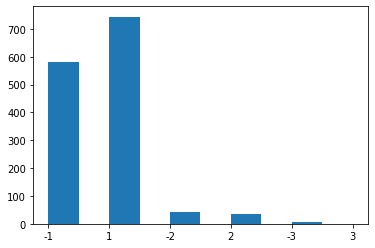

In [16]:
plt.hist(y_train)

(array([186.,   0., 133.,   0.,   4.,   0.,  19.,   0.,   9.,   2.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

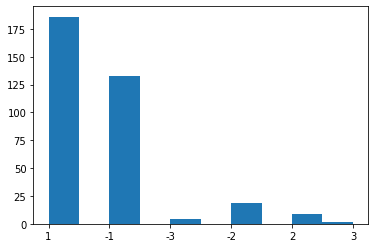

In [17]:
plt.hist(y_test)

In [18]:
pd.DataFrame(y_test).describe()

,price_movement
count,353
unique,6
top,1
freq,186


In [19]:
pd.DataFrame(y_train).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1408 entries, 2013-01-03 to 2018-08-06
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   price_movement  1408 non-null   object
dtypes: object(1)
memory usage: 22.0+ KB


<h2>
<center> Predict Volatility level and direction seperately in df9 </center>
</h2>

### break down our y-label into two parts: sign (+/-) and magnitude (1/2/3), called y1 and y2. We fit the features (technical indicators from “yesterday”) to y1 and y2 separately and test the model. 

In [15]:
df9 = df.copy()
col = 'pct'
conditions1  = [(df9[col] >= 0.03), 
               (df9[col] < 0.03) & (df9[col]>= 0.015),
               (df9[col] < 0.015) & (df9[col]>= 0.00),
               (df9[col] < 0.00) & (df9[col]>= -0.015),
               (df9[col] < -0.015) & (df9[col]>= -0.03),
               (df9[col] <= -0.03)
              ]
choices1  = ['3','2','1','1','2','3' ]

df9['price_movement'] = np.select(conditions1, choices1, default = np.nan)

conditions2  = [(df9[col] >= 0), 
                (df9[col] < 0)
              ]
choices2  = ['+','-']
df9['up_or_down'] = np.select(conditions2, choices2, default = np.nan)
df9

,High,Low,Open,Close,Volume,Adj Close,Momentum_1D,Momentum_5D,Momentum_10D,RSI_14D,...,12_EMA,MACD,MACD_signal,ATR,DI_plus,DI_minus,ADX,pct,price_movement,up_or_down
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,146.149994,144.729996,145.110001,146.059998,192059000.0,126.508362,3.649994,3.709991,2.289993,64.211520,...,142.894273,0.441928,0.441519,1.652140,54.876919,32.314073,22.449076,0.025630,2,+
2013-01-03,146.369995,145.339996,145.990005,145.729996,144761800.0,126.222488,-0.330002,3.979996,0.360001,69.744501,...,143.330538,0.635401,0.480296,1.624283,49.365932,28.005530,23.136879,-0.002259,1,-
2013-01-04,146.610001,145.669998,145.970001,146.369995,116817700.0,126.776825,0.639999,4.809998,2.080002,67.134156,...,143.798147,0.830796,0.550396,1.598570,44.785643,24.271459,24.012777,0.004392,1,+
2013-01-07,146.110001,145.429993,145.850006,145.970001,110002500.0,126.430382,-0.399994,5.940002,0.850006,67.544682,...,144.132278,0.942506,0.628818,1.612141,38.814224,23.020248,24.216720,-0.002733,1,-
2013-01-08,145.910004,144.979996,145.710007,145.550003,121265100.0,126.066605,-0.419998,3.139999,2.760010,69.113926,...,144.350390,0.985784,0.700211,1.557856,33.638994,23.802303,23.271127,-0.002877,1,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,321.519989,320.899994,321.470001,321.230011,20270000.0,319.352142,0.010010,1.660004,7.700012,67.076614,...,318.588601,3.310215,3.046026,1.499285,31.481583,10.573711,40.107975,0.000031,1,+
2019-12-26,322.950012,321.640015,321.649994,322.940002,30911200.0,321.052124,1.709991,3.350006,8.519989,69.183954,...,319.258047,3.412135,3.119248,1.559285,39.512066,9.163883,43.073230,0.005323,1,+
2019-12-27,323.799988,322.279999,323.739990,322.859985,42528800.0,320.972565,-0.080017,1.959991,5.729980,70.675046,...,319.812192,3.446718,3.184742,1.385712,42.422265,7.942032,46.458354,-0.000248,1,-


In [16]:
X_train, X_test, y_train1, y_test1, y_train2, y_test2 = train_test_split(df9.iloc[:(len(df8)-1),4:23], 
                                                                         df9["price_movement"][1:],
                                                                         df9['up_or_down'][1:],
                                                                         test_size=0.2, shuffle = False, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(array([1325.,    0.,    0.,    0.,    0.,   77.,    0.,    0.,    0.,
           6.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

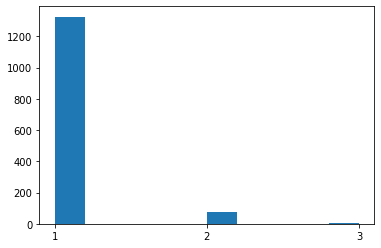

In [17]:
plt.hist(y_train1)

(array([319.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,  28.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

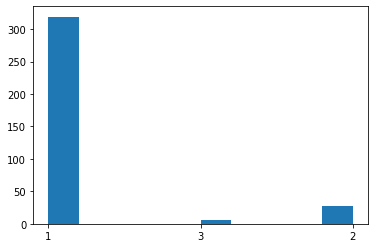

In [23]:
plt.hist(y_test1)

## Algorithm 1: Clustering(KMean) 
* Ruibo Wei

In [24]:
from sklearn.cluster import KMeans
k_range = range(3, 20, 1)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_scaled)
    kmeans_per_k.append(kmeans)

k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19


In [294]:
from sklearn.cluster import KMeans
k_range = range(3, 20, 1)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train)
    kmeans_per_k.append(kmeans)

k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19


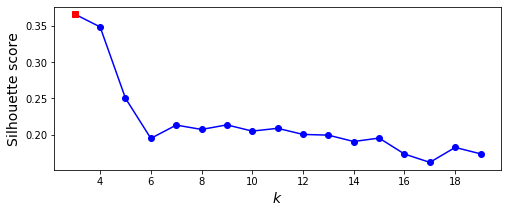

In [15]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = [silhouette_score(X_train_scaled, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(scores)
best_k = k_range[best_index]
best_score = scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [18]:
from sklearn.pipeline import Pipeline
for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators=500, random_state=42))
    ])
    pipeline.fit(X_train_scaled, y_train)
    print(n_clusters, pipeline.score(X_test_scaled, y_test))

3 0.5078740157480315
4 0.4921259842519685
5 0.484251968503937
6 0.49606299212598426
7 0.5039370078740157
8 0.484251968503937
9 0.4881889763779528
10 0.5196850393700787
11 0.5
12 0.5
13 0.49606299212598426
14 0.4881889763779528
15 0.5236220472440944
16 0.484251968503937
17 0.484251968503937
18 0.5
19 0.484251968503937


In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(3, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 97 candidates, totalling 291 fits
[CV] kmeans__n_clusters=3 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kmeans__n_clusters=3, total=   2.2s
[CV] kmeans__n_clusters=3 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=3, total=   2.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   2.3s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   2.6s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   2.7s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   2.8s
[CV] kmeans__n_clusters=5 ............................................
[CV] ............................. kmeans__n_clusters=5, total=   2.7s
[CV] kmeans__n_clusters=5 ............................................
[CV] ............................. kmeans__n_clusters=5, total=   2.6s
[CV] kmeans__n_clusters=5 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 291 out of 291 | elapsed: 28.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=19, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=19, tol=0.0001,
                                               verbose=0)),
                                       ('forest_clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gi...
                                                        

In [24]:
print(grid_clf.best_params_)
print(grid_clf.score(X_test_scaled, y_test))

{'kmeans__n_clusters': 96}
0.49606299212598426


### Breakdown the y label (y_train) to predict volatility level (y_train1) and direction of price change (y_train2) sepearately (df9)

In [17]:
for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators=500, random_state=42))
    ])
    pipeline.fit(X_train_scaled, y_train1)
    print("volatility level with k=",n_clusters, pipeline.score(X_test_scaled, y_test1))
    pipeline.fit(X_train_scaled, y_train2)
    print("direction of price change with k=", n_clusters, pipeline.score(X_test_scaled, y_test2))

volatility level with k= 3 0.952755905511811
direction of price change with k= 3 0.5118110236220472
volatility level with k= 4 0.9448818897637795
direction of price change with k= 4 0.5078740157480315
volatility level with k= 5 0.9488188976377953
direction of price change with k= 5 0.515748031496063
volatility level with k= 6 0.952755905511811
direction of price change with k= 6 0.5118110236220472
volatility level with k= 7 0.9488188976377953
direction of price change with k= 7 0.5
volatility level with k= 8 0.952755905511811
direction of price change with k= 8 0.484251968503937
volatility level with k= 9 0.952755905511811
direction of price change with k= 9 0.5
volatility level with k= 10 0.952755905511811
direction of price change with k= 10 0.5078740157480315
volatility level with k= 11 0.952755905511811
direction of price change with k= 11 0.5275590551181102
volatility level with k= 12 0.952755905511811
direction of price change with k= 12 0.5
volatility level with k= 13 0.95275590

## Algorithm 2 : XGB Classifier
* Zurui Chen

In [174]:
## Predict Volatility
xgb = XGBClassifier(eta=0.5,max_depth = 5,objective='multi:softprob',random_state=42) ###gradient boost tree, multiclass
xgb.fit(X_train_scaled[:1000], y_train[:1000],
        eval_set=[(X_train_scaled[1000:], y_train[1000:])], early_stopping_rounds=5)

[0]	validation_0-merror:0.44853
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.47549
[2]	validation_0-merror:0.45588
[3]	validation_0-merror:0.45833
[4]	validation_0-merror:0.44118
[5]	validation_0-merror:0.44853
[6]	validation_0-merror:0.46078
[7]	validation_0-merror:0.45833
[8]	validation_0-merror:0.45343
[9]	validation_0-merror:0.44608
Stopping. Best iteration:
[4]	validation_0-merror:0.44118



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [175]:
## report accuracy in test set
y_pred = xgb.predict(X_test_scaled)
accuracy_score(y_pred, y_test)

0.48725212464589235

### Hyperparameter tuning by using GridSearch, adding lambda for regularization to deal with overfitting.

In [181]:
from sklearn.model_selection import GridSearchCV
param = {'max_depth': [4,5,6,7,8], 
         'eta': [0.1,0.2,0.3,0.4,0.5,0.6,0.8],
         'min_child_weight':[0.2,0.5,1,1.5,2,3],
         'reg_lambda':[0.01,0.1,0.5,1,1.5,2,10],
         'reg_alpha':[1e-3, 1e-2, 0.1, 1, 10, 100],
        }
grid_search_1 = GridSearchCV(XGBClassifier(objective='multi:softprob'), param_grid = param, scoring='accuracy',n_jobs=-1,cv=3)
grid_search_1.fit(X_train_scaled, y_train)

C:\programming\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8],
                     

In [182]:
best_score = grid_search_1.best_score_
best_score

0.5255666953983879

In [183]:
best_model = grid_search_1.best_params_
best_model

{'eta': 0.1,
 'max_depth': 4,
 'min_child_weight': 2,
 'reg_alpha': 100,
 'reg_lambda': 10}

#### Implement the fine-tuned hyperparameter to fit the XGB Classifier

In [186]:
XGB = XGBClassifier(eta=0.1,max_depth = 4,objective='multi:softprob', 
                    min_child_weight= 2,reg_alpha = 100,reg_lambda = 10, random_state=42) ###gradient boost tree, multiclass
XGB.fit(X_train_scaled[:1000], y_train[:1000],
        eval_set=[(X_train_scaled[1000:], y_train[1000:])], early_stopping_rounds=5)


[0]	validation_0-merror:0.46324
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.45588
[2]	validation_0-merror:0.45588
[3]	validation_0-merror:0.45588
[4]	validation_0-merror:0.45098
[5]	validation_0-merror:0.44853
[6]	validation_0-merror:0.44853
[7]	validation_0-merror:0.45343
[8]	validation_0-merror:0.45098
[9]	validation_0-merror:0.45098
[10]	validation_0-merror:0.45098
Stopping. Best iteration:
[5]	validation_0-merror:0.44853



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=100,
              reg_lambda=10, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [187]:
y_prediction = XGB.predict(X_test_scaled)
accuracy_score(y_prediction, y_test)

0.5184135977337111

#### They accuracy improves.

C:\programming\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


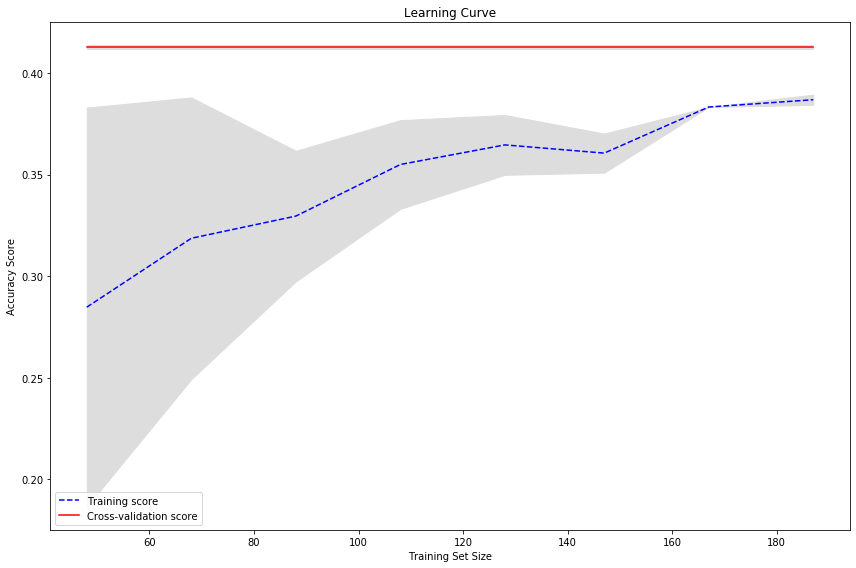

In [196]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(XGB, X_train_scaled, y_train,cv =3, scoring='accuracy', n_jobs=-1, 
                                               # 50 different sizes of the training set
                                               train_sizes=np.linspace(0.01, 0.2, 10))
    
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)    
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1) 
 # Draw lines
plt.subplots(figsize=(12,8))
plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")
# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout(); plt.show()

#### The learning curve tends to flatten out as the trianing size increase.

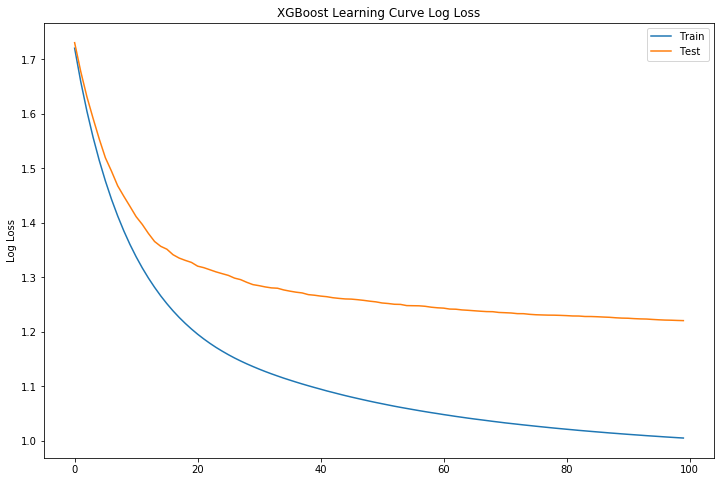

In [267]:
## test set
model_1 = XGB ## tuning the parameter
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
model_1.fit(X_train_scaled, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=False)

# retrieve performance metrics
results_1 = model_1.evals_result()
epochs = len(results_1['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,8))
ax.plot(x_axis, results_1['validation_0']['mlogloss'], label='Train') ## mlogloss – Multiclass negative log-likelihood
ax.plot(x_axis, results_1['validation_1']['mlogloss'], label='Test')
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Learning Curve Log Loss')
ax.legend()

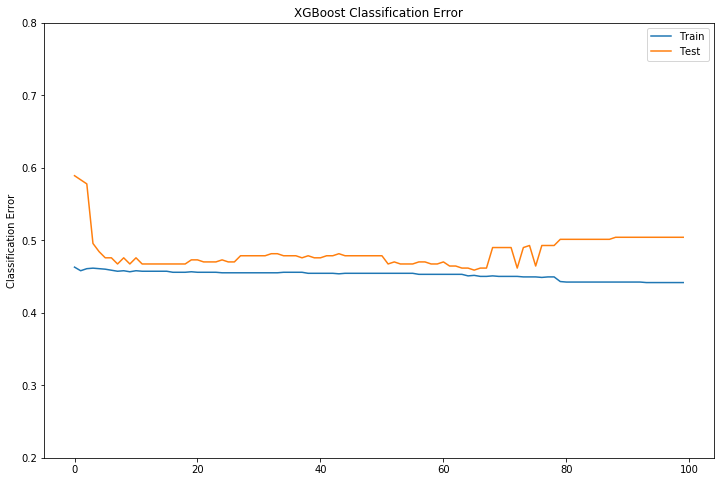

In [199]:
fig, ax = pyplot.subplots(figsize=(12,8))
ax.plot(x_axis, results_1['validation_0']['merror'], label='Train')
ax.plot(x_axis, results_1['validation_1']['merror'], label='Test')
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
ax.legend()
plt.ylim(0.2,0.8)
plt.show()

#### The classification error has around 50% for the testing set, which indicates limitation in accuracy for prediction. While the learning curve with the mlogloss (Multiclass negative log-likelihood) still indicates slightly overfit, which sugguest it to be an less ideal model.

In [50]:
### ROC_AUC
from sklearn.preprocessing import LabelBinarizer ### transform to perform one-vs-all scheme.
y_scores = cross_val_predict(xgb, X_train_scaled, y_train, cv=3)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print('In sample ROC_AUC score: ', multiclass_roc_auc_score(y_scores, y_train))

In sample ROC_AUC score:  0.5426386535479645


In [51]:
y_scores_1 = cross_val_predict(xgb, X_test_scaled, y_test, cv=3)
print('Out of sample ROC_AUC score: ', multiclass_roc_auc_score(y_scores_1, y_test))

C:\programming\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Out of sample ROC_AUC score:  0.5662290630664576


#### We investigate ROC_AUC score by binarizer (transform to perform one-vs-all scheme), which indicates the model should be valid.

In [25]:
## apply clustering before running xgboost
for n_clusters in range(2,20):
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("XGB", XGBClassifier(random_state=42))
    ])
    pipeline.fit(X_train_scaled, y_train)
    print(n_clusters, pipeline.score(X_test_scaled, y_test))

2 0.5275590551181102
3 0.5669291338582677
4 0.515748031496063
5 0.4763779527559055
6 0.49606299212598426
7 0.4566929133858268
8 0.5236220472440944
9 0.4763779527559055
10 0.49606299212598426
11 0.5118110236220472
12 0.5039370078740157
13 0.47244094488188976
14 0.5078740157480315
15 0.5
16 0.4881889763779528
17 0.5196850393700787
18 0.44881889763779526
19 0.4881889763779528


#### Best clustering into 3 groups before then use xgboost classifier to achieve 57% accuracy for testing set prediction. We are interested to look at where the classification error source from.

## Breakdown the y label (y_train) to predict volatility level (y_train1) and direction of price change (y_train2) sepearately (df9)

In [238]:
XGB.fit(X_train_scaled[:1000], y_train1[:1000],
        eval_set=[(X_train_scaled[1000:], y_train1[1000:])], early_stopping_rounds=5)

[0]	validation_0-merror:0.03922
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.03922
[2]	validation_0-merror:0.03922
[3]	validation_0-merror:0.03922
[4]	validation_0-merror:0.03922
[5]	validation_0-merror:0.03922
Stopping. Best iteration:
[0]	validation_0-merror:0.03922



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=100,
              reg_lambda=10, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [239]:
y_pred = XGB.predict(X_test_scaled)
accuracy_score(y_test1, y_pred)

0.9036827195467422

#### The accuracy of predicting the volatility level are pretty high.

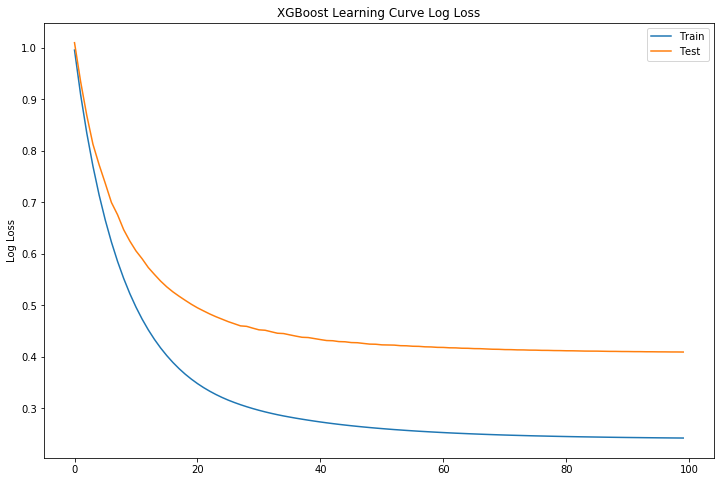

In [221]:
model_3 = XGB
eval_set = [(X_train_scaled, y_train1), (X_test_scaled, y_test1)]
model_3.fit(X_train_scaled, y_train1, eval_metric=["merror", "mlogloss"],early_stopping_rounds=5, eval_set=eval_set, verbose=False)

# retrieve performance metrics

results_3 = model_3.evals_result()
epochs = len(results_3['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,8))
ax.plot(x_axis, results_3['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results_3['validation_1']['mlogloss'], label='Test')
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Learning Curve Log Loss')
ax.legend()

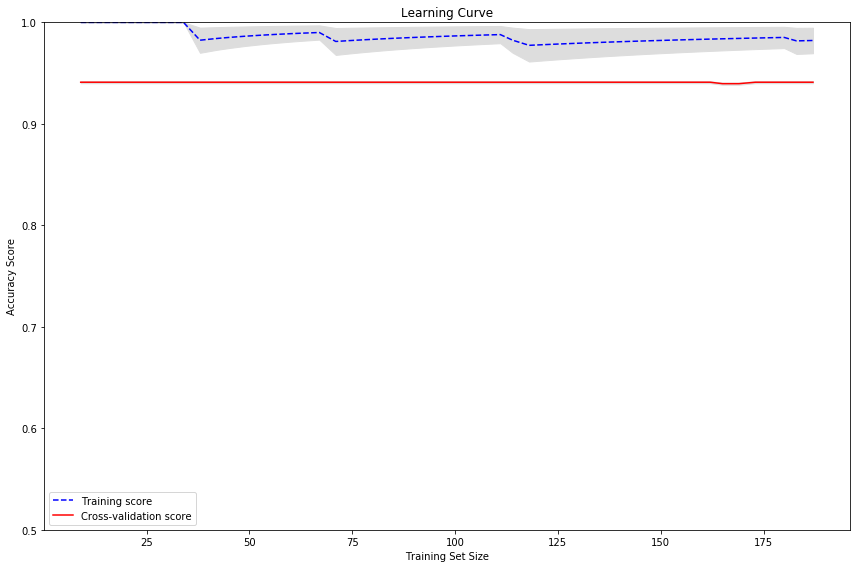

In [253]:
train_sizes, train_scores, test_scores = learning_curve(XGBClassifier(eta=0.1,max_depth = 4,min_child_weight= 2,random_state=42), 
                                               X_train_scaled, y_train1, scoring='accuracy',cv =3, n_jobs=-1, 
                                               # 50 different sizes of the training set
                                               train_sizes=np.linspace(0.01, 0.2, 50))
    
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
    
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
    
# Draw lines
plt.subplots(figsize=(12,8))
plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

    # Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.ylim(0.5,1)
plt.tight_layout(); plt.show()

### Predict direction of price change (price move up or down) on y_train2

In [247]:
xgb = XGBClassifier(eta=0.1,max_depth = 4,min_child_weight= 2,random_state=42)
xgb.fit(X_train_scaled[:1000], y_train2[:1000],
        eval_set=[(X_train_scaled[1000:], y_train2[1000:])], early_stopping_rounds=2)

[0]	validation_0-error:0.48284
Will train until validation_0-error hasn't improved in 2 rounds.
[1]	validation_0-error:0.46078
[2]	validation_0-error:0.46569
[3]	validation_0-error:0.46569
Stopping. Best iteration:
[1]	validation_0-error:0.46078



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [248]:
y_pred = xgb.predict(X_test_scaled)
accuracy_score(y_test2, y_pred)

0.5127478753541076

#### The learning curve flatten out as the training size increases.

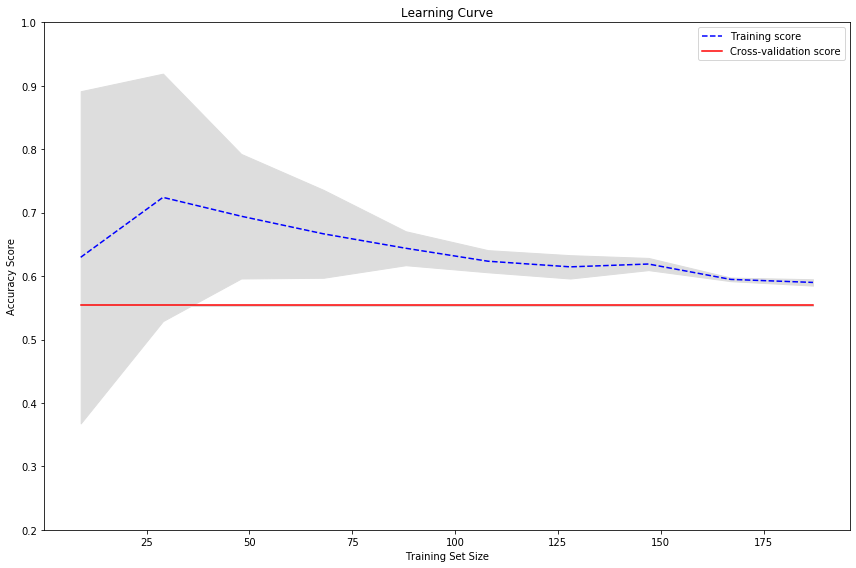

In [264]:
train_sizes, train_scores, test_scores = learning_curve(
    XGBClassifier(eta=0.1,max_depth = 4,min_child_weight= 2,reg_alpha =100,reg_lambda =10, random_state =42),        
                                               X_train_scaled, y_train2, scoring='accuracy',cv =3, n_jobs=-1, 
                                               # 50 different sizes of the training set
                                               train_sizes=np.linspace(0.01, 0.2, 10))
    
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
    
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
    
# Draw lines
plt.subplots(figsize=(12,8))
plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

    # Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.ylim(0.2,1)
plt.tight_layout(); plt.show()

#### Conclusion:  

#### We can see that XGB classifiers has slightly improve in accuracy after using clustering. Under the pipeline method, the accuracy using xgboost in predicting price movement comes to around 57%. The Hyperparameter tuning and regularization help to better fitting the model. The binarized ROC_AUC score for out of sample testing set is 56%. 

#### The result is fair and model should be vaild. By comparing the result of predicting volatility level and price change direction seperately, the model has good performance in classifying the volatility level, and the error mostly source from predicting the up trend or down trend. 

# Algorithm 3 : Voting Classifier
* Joice Dong

In [27]:
gbrt = GradientBoostingClassifier(max_depth=5,n_estimators=500,learning_rate=0.1,random_state=42)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=500,
                         algorithm="SAMME.R", learning_rate=0.1, random_state=42)
forest = RandomForestClassifier(n_jobs=-1,random_state=42)
extratree  = ExtraTreesClassifier(n_estimators=500,n_jobs=-1, random_state=42)
vote_s = VotingClassifier(estimators=[('forest', forest),
                                      ('extratree', extratree),
                                      ('ada', ada), 
                                      ('gbrt', gbrt)],
                          n_jobs=-1,
                          voting='soft')
vote_h = VotingClassifier(estimators=[('forest', forest),
                                      ('extratree', extratree),
                                      ('ada', ada), 
                                      ('gbrt', gbrt)],
                          n_jobs=-1,
                          voting='hard')

In [28]:
for clf in (gbrt, ada, forest, extratree,vote_s,vote_h):
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

GradientBoostingClassifier 0.5118110236220472
AdaBoostClassifier 0.4881889763779528


C:\Users\warre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier 0.5196850393700787
ExtraTreesClassifier 0.4881889763779528
VotingClassifier 0.49606299212598426
VotingClassifier 0.4921259842519685


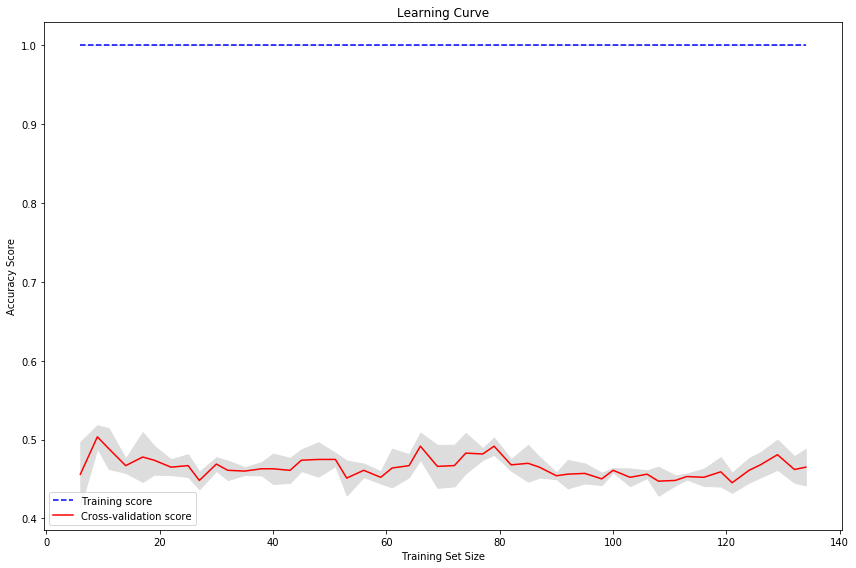

In [33]:
train_sizes, train_scores, test_scores = learning_curve(vote_s, 
                                               X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1, 
                                               # 50 different sizes of the training set
                                               train_sizes=np.linspace(0.01, 0.2, 50))
    
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
    
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
    
    # Draw lines
plt.subplots(figsize=(12,8))
plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

    # Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
    
    # Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout(); plt.show()

### Breakdown the y label (y_train) to predict volatility level (y_train1) and direction of price change (y_train2) sepearately (df9)

In [35]:
### predict the volatilty level (magnitude)
for clf in (gbrt, ada, forest, extratree,vote_s,vote_h):
    clf.fit(X_train_scaled, y_train1)
    y_pred = clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test1, y_pred))

GradientBoostingClassifier 0.9330708661417323
AdaBoostClassifier 0.9212598425196851
RandomForestClassifier 0.937007874015748
ExtraTreesClassifier 0.9448818897637795
VotingClassifier 0.9330708661417323
VotingClassifier 0.9448818897637795


In [30]:
### predict the direction of price change (up or down)
for clf in (gbrt, ada, forest, extratree,vote_s,vote_h):
    clf.fit(X_train_scaled, y_train2)
    y_pred = clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test2, y_pred))

GradientBoostingClassifier 0.515748031496063
AdaBoostClassifier 0.49606299212598426
RandomForestClassifier 0.5236220472440944
ExtraTreesClassifier 0.5669291338582677
VotingClassifier 0.5236220472440944
VotingClassifier 0.5354330708661418


# Algorithms 4: Blender 
* Chaoyi Lou


The blender algorithm has something in common with the voting algorithm, but the key point is that the blender combines the predictions results as the training set to do further model fitting. We use four individual classifiers mentioned in the previous algorithm which are listed below:

In [18]:
forest = RandomForestClassifier(n_jobs=-1,random_state=42) #from voting
extratree = ExtraTreesClassifier(n_estimators=500,n_jobs=-1, random_state=42) #voting
gbrt = GradientBoostingClassifier(max_depth=5,n_estimators=500,learning_rate=
0.1,random_state=42)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=500,algorithm="SAMME.R", learning_rate=0.1, random_state=42)

The very first step is getting our new training set for the blender. Additionally, we also get the cross validation scores for the four individual classifiers, which ranging from 10% to 50%.

In [20]:
from sklearn.model_selection import cross_val_predict, cross_val_score


models = [forest, extratree, ada, gbrt]
model_names = ["forest","extratree", "AdaBoost", "GradientBoost"]

pred = np.empty((len(X_train_scaled), len(models)), dtype=np.float32)

for index, model in enumerate(models):
    pred[:,index]=cross_val_predict(model, X_train_scaled, y_train,
                                  cv=3, n_jobs=-1)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=3,scoring="accuracy")
    print(scores)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[0.52765957 0.38166311 0.46268657]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[0.52765957 0.34115139 0.45202559]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[0.46808511 0.40724947 0.45202559]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[0.10851064 0.40085288 0.39872068]


Now we fit the blender on this new training set:

In [28]:
rnd_forest_blender = RandomForestClassifier(n_estimators=500,n_jobs=-1, oob_score=True, random_state=42)
rnd_forest_blender.fit(pred, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

The cross validation score from blender is not bad, which is around 50% in average. 

In [34]:
y_pred_train = cross_val_predict(rnd_forest_blender, pred, y_train,
                                  cv=3, n_jobs=-1)
cross_val_score(rnd_forest_blender, pred, y_train, cv=3,scoring="accuracy")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.53404255, 0.4989339 , 0.46055437])

From the confusion matrix, we can see the true positives mostly distributed in 1.

[[544   0   3 175  22   0]
 [ 14   0   0  18   3   0]
 [  1   0   0   0   0   0]
 [419   1   0 153   8   0]
 [ 21   0   1  16   4   0]
 [  2   0   0   2   1   0]]


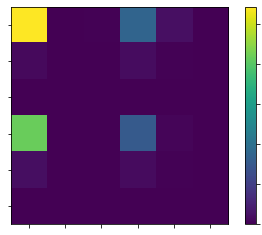

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_train, y_pred_train,labels=["1", "2", "3","-1","-2","-3"])
print(cm)
cm_display = ConfusionMatrixDisplay(cm,display_labels=["1", "2", "3","-1","-2","-3"]).plot()

Since this is a bagging ensemble of four different classifiers, we can request an automatic oob evaluation after training. 

In [30]:
rnd_forest_blender.oob_score_

0.5333806818181818

According to this oob evaluation, the blender is likely to achieve 53% accuracy on the test set. Now we can look at the actual performance on the test set and compare the result with previous models. 

In [31]:
X_test_predictions = np.empty((len(X_test), len(models)), dtype=np.float32)

for index, model in enumerate(models):
    X_test_predictions[:, index] = cross_val_predict(model, X_test, y_test,
                                  cv=3, n_jobs=-1)
    test_scores = cross_val_score(model, X_test, y_test, cv=3,scoring="accuracy")
    avg=0
    for i in range(len(test_scores)):
        avg=avg+test_scores[i]
    avg_score = avg/3
    print("avg",avg_score)
    print(test_scores)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


avg 0.42240088850258345
[0.30508475 0.43220339 0.52991453]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


avg 0.3857260128446569
[0.27966102 0.33050847 0.54700855]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


avg 0.44224733207784056
[0.39830508 0.37288136 0.55555556]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


avg 0.34893041672702685
[0.27966102 0.24576271 0.52136752]


From the results, we can see that forest and AdaBoost classifiers performs relatively better. Now we can look at the performance of the blender:

In [33]:
y_pred = cross_val_predict(rnd_forest_blender, X_test_predictions, y_test,
                                  cv=3, n_jobs=-1)
blender_acc=cross_val_score(rnd_forest_blender, X_test_predictions, y_test, cv=3,scoring="accuracy")
print(blender_acc)
avg=0
for i in range(len(blender_acc)):
    avg=avg+blender_acc[i]

blender_avg = avg/3
print("the average accuracy score from blender is: ", blender_avg)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[0.39830508 0.43220339 0.43589744]
the average accuracy score from blender is:  0.4221353034912357


[[92  4  0 90  0  0]
 [ 6  0  0  3  0  0]
 [ 1  0  0  1  0  0]
 [76  0  0 57  0  0]
 [10  0  0  9  0  0]
 [ 2  0  0  2  0  0]]


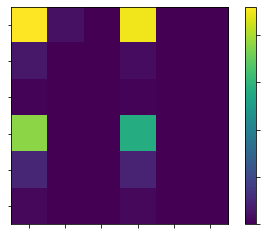

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_test, y_pred,labels=["1", "2", "3","-1","-2","-3"])
print(cm)
cm_display = ConfusionMatrixDisplay(cm,display_labels=["1", "2", "3","-1","-2","-3"]).plot()

## tuning the hyperparameter: including less classifiers
From the above results, we can see that the blender is not the best performed model. So we are curious about whether only including the two better-performed models in the blender will improve accuracy. 

In [36]:
models = [forest, ada]
model_names = ["forest", "AdaBoost"]

pred = np.empty((len(X_train_scaled), len(models)), dtype=np.float32)

for index, model in enumerate(models):
    pred[:,index]=cross_val_predict(model, X_train_scaled, y_train,
                                  cv=3, n_jobs=-1)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=3,scoring="accuracy")
    print(scores)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[0.52765957 0.38166311 0.46268657]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[0.46808511 0.40724947 0.45202559]


In [37]:
rnd_forest_blender = RandomForestClassifier(n_estimators=500,n_jobs=-1, oob_score=True, random_state=42)
rnd_forest_blender.fit(pred, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

The cross validation score and out of bag score of the blender improve a little bit.

In [38]:
cross_val_score(rnd_forest_blender, pred, y_train, cv=3,scoring="accuracy")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.52765957, 0.49680171, 0.52878465])

In [39]:
rnd_forest_blender.oob_score_

0.5248579545454546

Now we can take a look at the test sets of our new blender model:

In [40]:
X_test_predictions = np.empty((len(X_test), len(models)), dtype=np.float32)

for index, model in enumerate(models):
    X_test_predictions[:, index] = cross_val_predict(model, X_test, y_test,
                                  cv=3, n_jobs=-1)
    test_scores = cross_val_score(model, X_test, y_test, cv=3,scoring="accuracy")
    avg=0
    for i in range(len(test_scores)):
        avg=avg+test_scores[i]
    avg_score = avg/3
    print("avg",avg_score)
    print(test_scores)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


avg 0.42240088850258345
[0.30508475 0.43220339 0.52991453]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


avg 0.44224733207784056
[0.39830508 0.37288136 0.55555556]


In [41]:
cross_val_predict(rnd_forest_blender, X_test_predictions, y_test,
                                  cv=3, n_jobs=-1)
blender_acc=cross_val_score(rnd_forest_blender, X_test_predictions, y_test, cv=3,scoring="accuracy")
print(blender_acc)
avg=0
for i in range(len(blender_acc)):
    avg=avg+blender_acc[i]

blender_avg = avg/3
print("the average accuracy score from blender is: ", blender_avg)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


[0.48305085 0.5        0.52991453]
the average accuracy score from blender is:  0.5043217924573856


50%vs44.22%: We can see a clear improvement and now the blender algorithm outperforms. Now we can have a look at the learning curve.

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X_train,X_val, y_train,y_val):
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)  

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


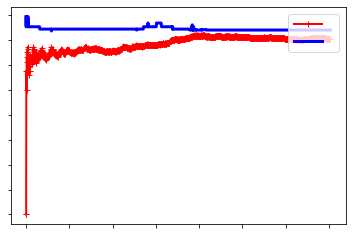

In [44]:
import matplotlib.pyplot as plt
plot_learning_curves(rnd_forest_blender, pred,X_test_predictions, y_train,y_test)
plt.show()

From the learning curve we can see that both have reached a plateau. They are close and fairly high, which means that this is typical of an underfitting model. This could be improved by adding more features to our training set, but if only focusing on the performance of the blender algorithm, we can see that by including models with better performance, the blender improves its accuracy. However, the accuracy is still not ideal to predict future volatility levels, so we break down the y label into one contains only the magnitude, and the other contains only the trend.

### Breakdown the y label (y_train) to predict volatility level (y_train1) and direction of price change (y_train2) sepearately (df9)

We repeat the steps we did previously, but only change the target group y. Here we only examine how the blender performs when predicting the magnitude. 

In [21]:
### predict the volatilty level (magnitude)

models = [forest, extratree, ada, gbrt]
model_names = ["forest","extratree", "AdaBoost", "GradientBoost"]

pred = np.empty((len(X_train_scaled), len(models)), dtype=np.float32)

for index, model in enumerate(models):
    pred[:,index]=cross_val_predict(model, X_train_scaled, y_train1,
                                  cv=3, n_jobs=-1)
    scores = cross_val_score(model, X_train_scaled, y_train1, cv=3,scoring="accuracy")
    avg=0
    for i in range(len(scores)):
        avg=avg+scores[i]
    avg_score = avg/3
    print("avg",avg_score)
    print(scores)


avg 0.717494593899802
[0.48510638 0.72707889 0.94029851]
avg 0.7953560465151446
[0.93404255 0.51172708 0.94029851]
avg 0.6567844667241302
[0.90425532 0.12366738 0.9424307 ]
avg 0.611067761496469
[0.22765957 0.68017058 0.92537313]


For the four individual classifiers, the accuracy improves when only looking at the magnitude. Now we can have a look at the performance of the blender:

In [22]:
blender = RandomForestClassifier(n_estimators=500,
                                 n_jobs=-1, random_state=42)
blender.fit(pred, y_train1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
cross_val_score(blender, pred, y_train1,
                                  cv=3, scoring="accuracy")

array([0.94042553, 0.42643923, 0.94029851])

The accuracy of the training set fitting seems higher than score of any of the four individual classifiers. Next, we look at the test set performance. 

In [24]:
for idx, model in enumerate(models):
    model.fit(X_train_scaled, y_train1)

In [25]:
pred_test = []
for idx, model in enumerate(models):
    pred_test.append(model.predict(X_test_scaled))
    scores = cross_val_score(model, X_test_scaled, y_test1, cv=3,scoring="accuracy")
    avg=0
    for i in range(len(scores)):
        avg=avg+scores[i]
    avg_score = avg/3
    print("avg",avg_score)
    print(scores)
pred_test = np.transpose(np.array(pred_test))

avg 0.7878700082089912
[0.55932203 0.89830508 0.90598291]
avg 0.7680959969095563
[0.54237288 0.8559322  0.90598291]
avg 0.7425756917282341
[0.5        0.8559322  0.87179487]
avg 0.7680235646337342
[0.52542373 0.89830508 0.88034188]


It seems that all the models perform better in the test set than in the training set. Now we look at the performance of the blender:

In [26]:
#accuracy for test set
blender_acc=cross_val_score(blender, pred_test, y_test1, cv=3,scoring="accuracy")
avg=0

for i in range(len(blender_acc)):
    avg=avg+blender_acc[i]

blender_avg = avg/3
print(blender_acc,"the average accuracy score from blender is: ", blender_avg)

[0.90677966 0.89830508 0.90598291] the average accuracy score from blender is:  0.9036892172485392


90% vs 74~78%. The blender outperforms! We can clearly see that the performance of the models for the test set is better than for the training set, and this trait also shows up in the learning curves. 

Now we can take a look at up and down trend. We choose the maginitude level 1 as a small sample.

In [27]:
choices3  = ['+1','-1']
y2_for_blender = np.select(conditions2, choices3, default = np.nan)
y_train2_blender, y_test2_blender = train_test_split(y2_for_blender[1:],test_size=0.2, random_state=42)

In [34]:
## predict uptrend or down trend
pred = []
for idx, model in enumerate(models):
    pred.append(cross_val_predict(model, X_train_scaled, y_train2_blender,
                                  cv=3, n_jobs=-1))
    scores = cross_val_score(model, X_train_scaled, y_train2_blender, cv=3,scoring="accuracy")
    avg=0
    for i in range(len(scores)):
        avg=avg+scores[i]
    avg_score = avg/3
    print("avg",avg_score)
    print(scores)
pred=np.transpose(np.array(pred))

avg 0.5114110299566
[0.44468085 0.53518124 0.554371  ]
avg 0.5092788337945531
[0.44468085 0.52878465 0.554371  ]
avg 0.49435346066022473
[0.44468085 0.49466951 0.54371002]
avg 0.5099880536527092
[0.44680851 0.53731343 0.54584222]


In [35]:
blender = RandomForestClassifier(n_estimators=500,
                                 n_jobs=-1, random_state=42)
blender.fit(pred, y_train2_blender)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [37]:
cross_val_score(blender, X_train_scaled, y_train2_blender, cv=3,scoring="accuracy")

array([0.44468085, 0.53518124, 0.554371  ])

For the up/down trend prediction, we can see that the blender also outperforms in the training set. Now we can have a look at the performance of test set:


In [28]:
for idx, model in enumerate(models):
    model.fit(X_train_scaled, y_train2_blender) #fit the 4 models

In [29]:
pred_test = []
for idx, model in enumerate(models):
    pred_test.append(cross_val_predict(model, X_test_scaled, y_test2_blender,
                                  cv=3, n_jobs=-1)) #predict for test set
    scores = cross_val_score(model, X_test_scaled, y_test2_blender, cv=3,scoring="accuracy")
    avg=0
    for i in range(len(scores)):
        avg=avg+scores[i]
    avg_score = avg/3
    print("avg",avg_score)
    print(scores)
pred_test = np.transpose(np.array(pred_test))

avg 0.5072432275822106
[0.42372881 0.53389831 0.56410256]
avg 0.48169877830894786
[0.45762712 0.46610169 0.52136752]
avg 0.4732483461297021
[0.39830508 0.49152542 0.52991453]
avg 0.4901009223043122
[0.48305085 0.49152542 0.4957265 ]


In [30]:
blender_acc=cross_val_score(blender, pred_test, y_test2_blender, cv=3,scoring="accuracy")
avg=0

for i in range(len(blender_acc)):
    avg=avg+blender_acc[i]

blender_avg = avg/3
print(blender_acc,"the average accuracy score from blender is: ", blender_avg)

[0.42372881 0.51694915 0.5042735 ] the average accuracy score from blender is:  0.4816504901250664


When breaking down the y label, Blender prediction has decent performance in predicting volatility level in comparsion to other algorithms. However, the preformance of predicting signs is not so significant among the algorithms we used so far. In real life, since stocks are risky and the trend is stochastic, it is difficult to predict the future based on the history. But the blender algorithm is still a good source to reply on comparing to other sources. 

# Section 4 Summary

With an at most 53% of accuracy, we are also curious about where the error come from. Based on this question, we break down our y-label into two parts: sign (+/-) and magnitude (1/2/3), called y1 and y2. We fit the features (technical indicators from “yesterday”) to y1 and y2 separately and test the model. We find that our model is good at predicting the magnitude of next day price movement and the accuracy can be up to 95%. However, the model cannot explain and predict the direction of the movement well. If we want to use the model to predict whether the next day movement will be upward or downward, the accuracy will only be around 50%. 

Based on our break down research, we find that the errors of our original model come from the inaccuracy of explaining the movement direction. In this case, we conclude two direction for further research. First, we can find a better model to explain and predict the direction of the next day price movement. Then we will be able to predict the direction of the movement and the magnitude of the movement by combining the two models. One potential way to achieve this may be to change rolling timeline from 1-day period to 5-day period or 20-day period. Another potential way to achieve this is to find different features to fit a new model. However, based on our research, the accuracy of the models for predicting the direction of movement from other finance professions is around 60%. Therefore, it will be hard for us to improve our original model in this way. Secondly, we may focus only on the magnitude of next day price movement. There are multiple applications, such as the risk management for leveraged derivative, application of straddle options strategy, and application of butterfly spread strategy. 

* Blender 

By going through the df8 and df9 data set, our conclusion is that the blender algorithm outperforms in most cases. By including more robust individual models, the blender improves its accuracy. When breaking down the y label to the magnitude and the trend, we know that the factor influencing the whole accuracy is the difficulty to predict the trend. However, if only looking at the magnitude, the blender is a good source to rely on. For further more accurate predictions, we can include more related features and more robust individual classifiers in order to have a better performed blender. 